In [1]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN, Siren
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Clustering, Threshold
from deepymod_torch.training import train
from deepymod_torch.training.sparsity_scheduler import Periodic
from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta

import matplotlib.pyplot as plt
from phi

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

In [3]:
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.10, normalize=True, random=True)

# SIREN no scaling

In [5]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=1, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=5000, periodicity=5) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [6]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/no_scaling/', write_iterations=1, max_iterations=2000, delta=0.0) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       2000    100.00%               0s   -1.26e+01   2.77e-04   1.85e-05   2.01e+00 

# Siren with scaling

In [12]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=1, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=5000, periodicity=5) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [13]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/with_scaling/', write_iterations=1, max_iterations=2000, delta=0.0) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       2000    100.00%               0s   -2.26e+01   1.85e-06   4.00e-07   1.41e+00 

# Normal no scaling

# Normal with scaling

In [44]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=1, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=5000, periodicity=5) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [45]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/NN_with_scaling/', write_iterations=1, max_iterations=2000, delta=0.0) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       2000    100.00%               0s   -1.24e+01   3.24e-04   4.30e-06   1.68e+00 

# Comparing

In [14]:
from phimal_utilities.analysis import Results

In [46]:
data_no_scaling = Results('runs/no_scaling/')
data_with_scaling = Results('runs/with_scaling/')
data_NN_with_scaling = Results('runs/NN_with_scaling/')

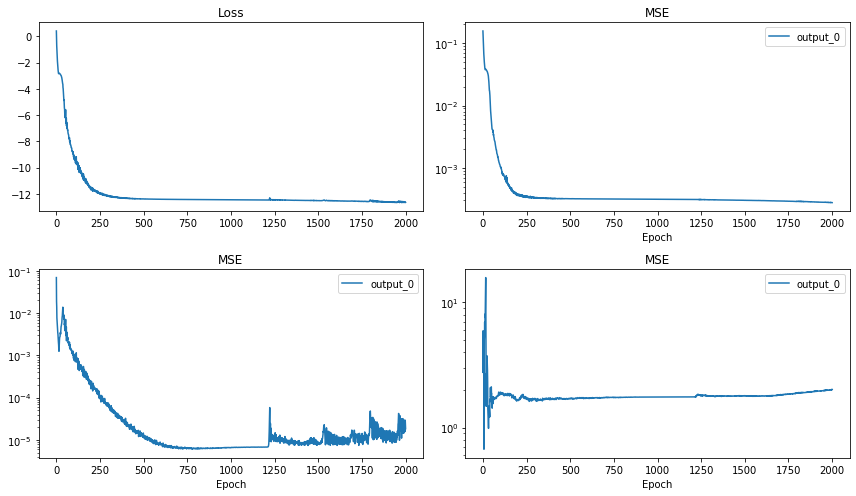

In [17]:
data_no_scaling.plot_losses()

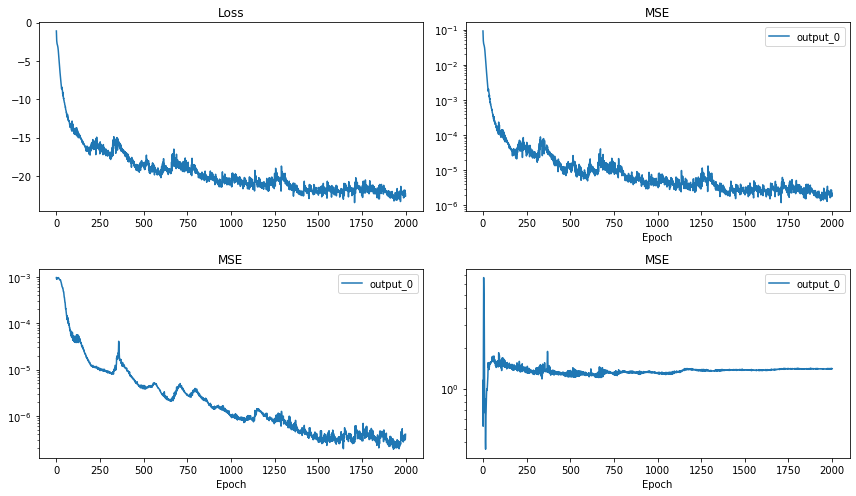

In [20]:
data_with_scaling.plot_losses()

Thats a big difference... Let's plot the coeff_error

In [57]:
# Rescaling coordinates

true_coeffs = np.zeros((1, 8))
true_coeffs[0, 2] = 0.1 * dataset.scaling_factor[1][1]**2 / dataset.scaling_factor[1][0]
true_coeffs[0, 5] = -1 * dataset.scaling_factor[1][1] / dataset.scaling_factor[1][0]

In [58]:
no_scaling_error = np.mean(np.abs(data_no_scaling.df[data_no_scaling.keys['unscaled_coeffs']] - true_coeffs), axis=1)
with_scaling_error = np.mean(np.abs(data_with_scaling.df[data_with_scaling.keys['unscaled_coeffs']] - true_coeffs), axis=1)
NN_with_scaling_error = np.mean(np.abs(data_NN_with_scaling.df[data_NN_with_scaling.keys['unscaled_coeffs']] - true_coeffs), axis=1)

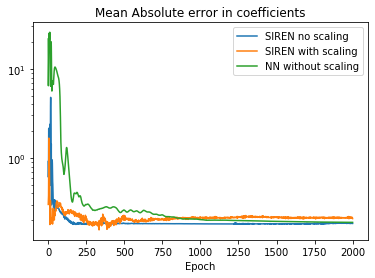

In [59]:
plt.semilogy(no_scaling_error, label='SIREN no scaling')
plt.semilogy(with_scaling_error, label='SIREN with scaling')
plt.semilogy(NN_with_scaling_error, label='NN without scaling')

plt.legend()
plt.xlabel('Epoch')
plt.title('Mean Absolute error in coefficients')

plt.show()

In [56]:
dataset.scaling_factor[1][0]

2.25

In [60]:
true_coeffs

array([[ 0.        ,  0.        ,  0.54444444,  0.        ,  0.        ,
        -1.55555556,  0.        ,  0.        ]])